## Demand Estimation with PyBLP

**Taisei Noda**
2022/12/4

In [1]:
#!pip install pyblp

# To make jupyter slides, run the following commands on cmd:

# jupyter nbconvert --to slides C:\Users\Taise\directory\MutualFundManager\PyBLP_MutualFund.ipynb
# jupyter nbconvert C:\Users\Taise\directory\MutualFundManager\PyBLP_MutualFund.ipynb --to slides --post serve 

#jupyter nbconvert --to slides C:\Users\Taise\Documents\GitHub\MutualFundManager\PyBLP_MutualFund.ipynb
#jupyter nbconvert C:\Users\Taise\Documents\GitHub\MutualFundManager\PyBLP_MutualFund.ipynb --to slides --post serve 


In [2]:
import pyblp
import numpy as np
import pandas as pd

pyblp.options.digits = 4
pyblp.options.verbose = False
pyblp.__version__
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Part I. Walking Through [the Tutorials](https://pyblp.readthedocs.io/en/stable/) 

In [3]:
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
product_data.head()

,market_ids,city_ids,quarter,product_ids,firm_ids,brand_ids,shares,prices,sugar,mushy,...,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
0,C01Q1,1,1,F1B04,1,4,0.0124,0.0721,2,1,...,2.1164,-0.1547,-0.0058,0.0145,0.1262,0.0673,0.0684,0.0348,0.1263,0.0355
1,C01Q1,1,1,F1B06,1,6,0.0078,0.1142,18,1,...,-7.3741,-0.5764,0.0130,0.0761,0.0297,0.0879,0.1105,0.0878,0.0499,0.0726
2,C01Q1,1,1,F1B07,1,7,0.0130,0.1324,4,1,...,2.1879,-0.2073,0.0035,0.0918,0.1638,0.1119,0.1082,0.0864,0.1223,0.1018
3,C01Q1,1,1,F1B09,1,9,0.0058,0.1303,3,0,...,2.7046,0.0407,-0.0037,0.0947,0.1353,0.0881,0.1018,0.1018,0.1107,0.1043
4,C01Q1,1,1,F1B11,1,11,0.0179,0.1548,12,0,...,1.2612,0.0348,-0.0006,0.1025,0.1306,0.0848,0.1011,0.1252,0.1335,0.1211


In [4]:
print(product_data.groupby('market_ids')['shares'].sum())

market_ids
C01Q1   0.4448
C01Q2   0.4973
C03Q1   0.4148
C03Q2   0.3384
C04Q1   0.6686
         ...  
C61Q2   0.4410
C63Q1   0.6354
C63Q2   0.6095
C65Q1   0.4256
C65Q2   0.3575
Name: shares, Length: 94, dtype: float64


**Arguments**

* `market_ids` : PyBLP recognizes whether products are in the same market or not. Denoted by $t \in T$
* `product_ids` : Can take the product-level fixed effects 
* `shares` : the market shares which must be between zero and one, and within a market ID, $\sum_j s_{j t} \leq 1$
* `prices` : endogenous variables
* `firm_ids` :




#### Application 1: Plain Logit

Suppose the indirect utility is given by:

\begin{equation*}
U_{i j t}=\alpha p_{j t}+x_{j t} \beta^{\mathrm{ex}}+\xi_{j t}+\epsilon_{i j t},
\end{equation*}
where $\epsilon_{ijt}$ is distributed IID with the Type I Extreme Value distribution.

Let normalize the mean utility of the outside good to zero so that $U_{i 0 t}=\epsilon_{i 0 t}$.

This gives us aggregate market shares:

\begin{equation*}
s_{j t}=\frac{\exp \left(\alpha p_{j t}+x_{j t} \beta^{\mathrm{ex}}+\xi_{j t}\right)}{1+\sum_k \exp \left(\alpha p_{k t}+x_{k t} \beta^{\mathrm{ex}}+\xi_{k t}\right)} .
\end{equation*}

Taking log yiels:

\begin{equation*}
\log s_{j t}=\alpha p_{j t}+x_{j t} \beta^{\text {ex }}+\xi_{j t}-\log \sum_k \exp \left(\alpha p_{k t}+x_{k t} \beta^{\text {ex }}+\xi_{k t}\right)
\end{equation*}

and 

\begin{equation*}
\log s_{0 t}=-\log \sum_k \exp \left(\alpha p_{k t}+x_{k t} \beta^{\mathrm{ex}}+\xi_{k t}\right)
\end{equation*}

By differencing, we get

\begin{equation*}
\log s_{j t}-\log s_{0 t}=\alpha p_{j t}+x_{j t} \beta^{\text {ex }}+\xi_{j t} .
\end{equation*}

We can estimate parameters by linear IV-GMM

In [5]:
# Set up the Problem
logit_formulation = pyblp.Formulation('prices', absorb='C(product_ids)')
logit_formulation

prices + Absorb[C(product_ids)]

In [6]:
problem = pyblp.Problem(logit_formulation, product_data)
problem

Dimensions:
 T    N     F    K1    MD    ED 
---  ----  ---  ----  ----  ----
94   2256   5    1     20    1  

Formulations:
     Column Indices:          0   
--------------------------  ------
X1: Linear Characteristics  prices

In [7]:
logit_results = problem.solve()
logit_results

Problem Results Summary:
GMM   Objective   Clipped  Weighting Matrix
Step    Value     Shares   Condition Number
----  ----------  -------  ----------------
 2    +1.875E+02     0        +5.682E+07   

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
   prices   
------------
 -3.005E+01 
(+1.009E+00)

#### Application 2: Nested Logit

We can extend the logit model to allow for correltation within a group $h$ so that

\begin{equation*}
U_{i j t}=\alpha p_{j t}+x_{j t} \beta^{\text {ex }}+\xi_{j t}+\bar{\epsilon}_{h(j) t i}+(1-\rho) \bar{\epsilon}_{i j t} .
\end{equation*}

We require that $\epsilon_{j t i}=\bar{\epsilon}_{h(j) t i}+(1-\rho) \bar{\epsilon}_{j t i}$ is distributed IID with the Type I Extreme Value distribution.

As $\rho \rightarrow 1$, all consumers stay within their group. As $\rho \rightarrow 0$, this collapses to the IIA logit.

Note that if we wanted, we could allow $\rho$ to differ between groups with $\rho_{h(j)}$.


\begin{equation*}
s_{j t}=\frac{\exp \left[V_{j t} /(1-\rho)\right]}{\exp \left[V_{h(j) t} /(1-\rho)\right]} \cdot \frac{\exp V_{h(j) t}}{1+\sum_h \exp V_{h t}}
\end{equation*}

where $V_{j t}=\alpha p_{j t}+x_{j t} \beta^{e x}+\xi_{j t}$



After some work

\begin{equation*}
\log s_{j t}-\log s_{0 t}=\alpha p_{j t}+x_{j t} \beta^{e x}+\rho \log s_{j \mid h(j) t}+\xi_{j t}
\end{equation*}

where $s_{j \mid h(j) t}=s_{j t} / s_{h(j) t}$ and $s_{h(j) t}$ is the share of group $h$ in market $t$.

Since $\ln s_{j \mid h(j) t}$ would be endogenous, we should write:

\begin{equation*}
\log s_{j t}-\log s_{0 t}-\rho \log s_{j \mid h(j) t}=\alpha p_{j t}+x_{j t} \beta^{\mathrm{ex}}+\xi_{j t}
\end{equation*}

The extension requires an additional instrument. A common choice is the number of products per nest.

#### Additional arguments for the nested logit:

* `nesting_ids` : group identification
* `demand_instruments20` : the additional instrument for the share within the group

##### Case 1: Single nest (idential to plain logit)

In [8]:
def seeproblem_nl(df):
    groups = df.groupby(['market_ids', 'nesting_ids'])
    df['demand_instruments20'] = groups['shares'].transform(np.size) #construct IV
    nl_formulation = pyblp.Formulation('0 + prices')
    problem = pyblp.Problem(nl_formulation, df)
    return problem

In [9]:
def solve_nl(df):
    groups = df.groupby(['market_ids', 'nesting_ids'])
    df['demand_instruments20'] = groups['shares'].transform(np.size) #construct IV
    nl_formulation = pyblp.Formulation('0 + prices')
    problem = pyblp.Problem(nl_formulation, df)
    return problem.solve(rho=0.7) #need initial value for rho

In [10]:
df1 = product_data.copy()
df1['nesting_ids'] = 1
seeproblem_nl(df1)

Dimensions:
 T    N     F    K1    MD    H 
---  ----  ---  ----  ----  ---
94   2256   5    1     21    1 

Formulations:
     Column Indices:          0   
--------------------------  ------
X1: Linear Characteristics  prices

In [11]:
df1 = product_data.copy()
df1['nesting_ids'] = 1
nl_results1 = solve_nl(df1)
nl_results1

Problem Results Summary:
GMM   Objective     Projected     Reduced    Clipped  Weighting Matrix  Covariance Matrix
Step    Value     Gradient Norm   Hessian    Shares   Condition Number  Condition Number 
----  ----------  -------------  ----------  -------  ----------------  -----------------
 2    +2.033E+02   +2.398E-09    +1.074E+04     0        +2.005E+09        +3.028E+04    

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:02       Yes          3             8     

Rho Estimates (Robust SEs in Parentheses):
 All Groups 
------------
 +9.826E-01 
(+1.358E-02)

Beta Estimates (Robust SEs in Parentheses):
   prices   
------------
 -1.173E+00 
(+3.971E-01)

##### Case 2: Grouped by `mushy`

In [12]:
df2 = product_data.copy()
df2['nesting_ids'] = df2['mushy']
nl_results2 = solve_nl(df2)
nl_results2

Problem Results Summary:
GMM   Objective     Projected     Reduced    Clipped  Weighting Matrix  Covariance Matrix
Step    Value     Gradient Norm   Hessian    Shares   Condition Number  Condition Number 
----  ----------  -------------  ----------  -------  ----------------  -----------------
 2    +6.903E+02   +8.797E-09    +5.610E+03     0        +5.118E+08        +1.992E+04    

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:05       Yes          5            31     

Rho Estimates (Robust SEs in Parentheses):
 All Groups 
------------
 +8.915E-01 
(+1.913E-02)

Beta Estimates (Robust SEs in Parentheses):
   prices   
------------
 -7.838E+00 
(+4.815E-01)

The own price elasticity of good $j$ in nest $g$ is:

\begin{equation*}
\eta_{j j}=\frac{\alpha}{1-\sigma} p_j-\frac{\alpha}{1-\sigma} s_{j \mid h(j) t} p_j+\alpha\left(1-s_{h(j)}\right) s_{j \mid h(j) t} p_{j}
\end{equation*}

In [13]:
# single nest
nl_results1.beta[0] / (1 - nl_results1.rho)

array([[-67.39338888]])

In [14]:
# multiple nests
nl_results2.beta[0] / (1 - nl_results2.rho)

array([[-72.27074638]])

#### Application 3: Random Coefficients 

\begin{equation*}
u_{i j t}=\alpha_i p_{j t}+x_{j t} \beta_i^{\text {ex }}+\xi_{j t}+\epsilon_{i j t}
\end{equation*}

The individual market share is:

\begin{equation*}
s_{j t}(\alpha, \beta, \theta)=\int \frac{\exp \left(\alpha_i p_{j t}+x_{j t} \beta_i^{\text {ex }}+\xi_{j t}\right)}{1+\sum_k \exp \left(\alpha_i p_{j t}+x_{k t} \beta_i^{\operatorname{ex}}+\xi_{k t}\right)} f\left(\alpha_i, \beta_i \mid \theta\right) .
\end{equation*}

Rewrite:

\begin{equation*}
s_{j t}\left(\delta_{j t}, \theta\right)=\int \frac{\exp \left(\delta_{j t}+\mu_{i j t}\right)}{1+\sum_k \exp \left(\delta_{k t}+\mu_{i k t}\right)} f\left(\mu_{i t} \mid \theta\right) .
\end{equation*}


We can perform a linear IV GMM regresion:
\begin{equation*}
\delta_{j t}(\theta)=\alpha p_{j t}+x_{j t} \beta^{e x}+\xi_{j t}
\end{equation*}

The moments are constructed by interacting the predicted residials with instruments to form:

\begin{equation*}
\bar{g}(\theta)=\frac{1}{N} \sum_{j, t} z_{j t}^{\prime} \hat{\xi}_{j t}(\theta)
\end{equation*}

##### Step 1.

Load the `product data` which at a minimum consists of `market_ids`, `shares`, `prices`, and at least a single column of demand instruments, `demand_instruments0`.

In [15]:
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
product_data.head()

,market_ids,city_ids,quarter,product_ids,firm_ids,brand_ids,shares,prices,sugar,mushy,...,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
0,C01Q1,1,1,F1B04,1,4,0.0124,0.0721,2,1,...,2.1164,-0.1547,-0.0058,0.0145,0.1262,0.0673,0.0684,0.0348,0.1263,0.0355
1,C01Q1,1,1,F1B06,1,6,0.0078,0.1142,18,1,...,-7.3741,-0.5764,0.0130,0.0761,0.0297,0.0879,0.1105,0.0878,0.0499,0.0726
2,C01Q1,1,1,F1B07,1,7,0.0130,0.1324,4,1,...,2.1879,-0.2073,0.0035,0.0918,0.1638,0.1119,0.1082,0.0864,0.1223,0.1018
3,C01Q1,1,1,F1B09,1,9,0.0058,0.1303,3,0,...,2.7046,0.0407,-0.0037,0.0947,0.1353,0.0881,0.1018,0.1018,0.1107,0.1043
4,C01Q1,1,1,F1B11,1,11,0.0179,0.1548,12,0,...,1.2612,0.0348,-0.0006,0.1025,0.1306,0.0848,0.1011,0.1252,0.1335,0.1211


In [16]:
product_data.columns

Index(['market_ids', 'city_ids', 'quarter', 'product_ids', 'firm_ids',
       'brand_ids', 'shares', 'prices', 'sugar', 'mushy',
       'demand_instruments0', 'demand_instruments1', 'demand_instruments2',
       'demand_instruments3', 'demand_instruments4', 'demand_instruments5',
       'demand_instruments6', 'demand_instruments7', 'demand_instruments8',
       'demand_instruments9', 'demand_instruments10', 'demand_instruments11',
       'demand_instruments12', 'demand_instruments13', 'demand_instruments14',
       'demand_instruments15', 'demand_instruments16', 'demand_instruments17',
       'demand_instruments18', 'demand_instruments19'],
      dtype='object')

##### Step 2. Define a [`Formulation`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Formulation.html#pyblp.Formulation) for the $X_1$ (**linear**) demand model.

In [17]:
X1_formulation = pyblp.Formulation('0 + prices', absorb='C(product_ids)')

##### Step 3. Define a [`Formulation`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Formulation.html#pyblp.Formulation) for the $X_2$ (nonlinear) demand model.

- Include only the variables over which we want random coefficients.
- Do not absorb or include fixed effects.
- It will include a random coefficient on the constant (to capture inside good vs. outside good preference) unless you specify not to with a `0` or a `-1`.

In [18]:
X2_formulation = pyblp.Formulation('1 + prices + sugar + mushy')


In [19]:
product_formulations = (X1_formulation, X2_formulation)
product_formulations

(prices + Absorb[C(product_ids)], 1 + prices + sugar + mushy)

#### Step 4. Define an [`Integration`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Integration.html#pyblp.Integration) configuration

Availabe options:

- Monte Carlo integration (pseudo-random draws).
- Product rule quadrature.
- Sparse grid quadrature.

In [20]:
pr_integration = pyblp.Integration('product', size=5)
pr_integration

Configured to construct nodes and weights according to the level-5 Gauss-Hermite product rule with options {}.

##### Step 5. Combine [`Formulation`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Formulation.html#pyblp.Formulation) classes, `product_data`, and the [`Integration`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Integration.html#pyblp.Integration) configuration to construct a [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem).


In [21]:
pr_problem = pyblp.Problem(product_formulations, product_data, integration=pr_integration)
pr_problem

Dimensions:
 T    N     F     I     K1    K2    MD    ED 
---  ----  ---  -----  ----  ----  ----  ----
94   2256   5   58750   1     4     20    1  

Formulations:
       Column Indices:           0       1       2      3  
-----------------------------  ------  ------  -----  -----
 X1: Linear Characteristics    prices                      
X2: Nonlinear Characteristics    1     prices  sugar  mushy

#### Step 6. Use the [`Problem.solve`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.solve.html#pyblp.Problem.solve) method to estimate paramters.

In [22]:
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})
bfgs

Configured to optimize using the BFGS algorithm implemented in SciPy with analytic gradients and options {gtol: +1.000E-04}.

##### Results

In [23]:
results1 = pr_problem.solve(sigma=np.ones((4, 4)), optimization=bfgs)
results1

Problem Results Summary:
GMM   Objective    Gradient       Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value        Norm     Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ----------  ----------  --------------  --------------  -------  ----------------  -----------------
 2    +1.590E+02  +3.213E-05    +1.574E-02      +5.264E+03       0        +5.293E+07        +3.696E+21    

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:04:55       Yes          64           78          67005       207153   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:       1           prices        sugar         mushy      |  Sigma Squared:       1           prices        sugar         mushy    
------  -----------

#### Post-Estimation: Elasticities and Diversion ratio

Elasticities:

\begin{equation*}
\varepsilon_{j k}=\frac{x_k}{s_j} \frac{\partial s_j}{\partial x_k}
\end{equation*}

Diversion ratio:

\begin{equation*}
\mathcal{D}_{j k}=-\frac{\partial s_k}{\partial x_j} / \frac{\partial s_j}{\partial x_j}
\end{equation*}



In [24]:
elasticities = results1.compute_elasticities()
diversions = results1.compute_diversion_ratios()

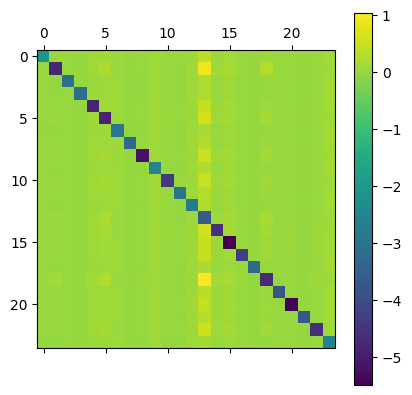

In [25]:
single_market = product_data['market_ids'] == 'C01Q1'
import matplotlib.pyplot as plt
plt.colorbar(plt.matshow(elasticities[single_market]))

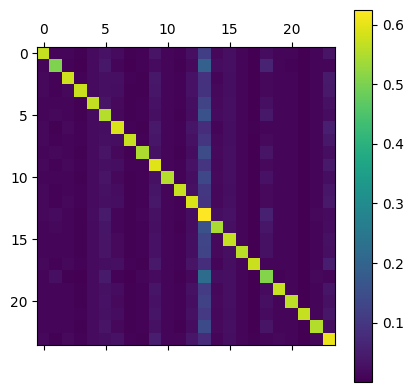

In [26]:
plt.colorbar(plt.matshow(diversions[single_market]))

#### Problem Simulation Tutorial

In [32]:

id_data = pyblp.build_id_data(T=50, J=20, F=10)
type(id_data)

numpy.recarray

In [31]:
integration = pyblp.Integration('product', 9)
integration

Configured to construct nodes and weights according to the level-9 Gauss-Hermite product rule with options {}.

In [33]:

simulation = pyblp.Simulation(
   product_formulations=(
       pyblp.Formulation('1 + prices + x'),
       pyblp.Formulation('0 + x'),
       pyblp.Formulation('0 + x + z')
   ),
   beta=[1, -2, 2],
   sigma=1,
   gamma=[1, 4],
   product_data=id_data,
   integration=integration,
   seed=0
)
simulation

Dimensions:
 T    N     F    I    K1    K2    K3 
---  ----  ---  ---  ----  ----  ----
50   1000  10   450   3     1     2  

Formulations:
        Column Indices:           0     1      2 
-------------------------------  ---  ------  ---
  X1: Linear Characteristics      1   prices   x 
 X2: Nonlinear Characteristics    x              
X3: Linear Cost Characteristics   x     z        

Nonlinear Coefficient True Values:
Sigma:     x    
------  --------
  x     +1.0E+00

Beta True Values:
   1       prices      x    
--------  --------  --------
+1.0E+00  -2.0E+00  +2.0E+00

Gamma True Values:
   x         z    
--------  --------
+1.0E+00  +4.0E+00

In [35]:
simulation_results = simulation.replace_endogenous()
simulation_results

Simulation Results Summary:
Computation  Fixed Point  Fixed Point  Contraction  Profit Gradients  Profit Hessians  Profit Hessians
   Time       Failures    Iterations   Evaluations      Max Norm      Min Eigenvalue   Max Eigenvalue 
-----------  -----------  -----------  -----------  ----------------  ---------------  ---------------
 00:00:00         0           721          721          +1.3E-13         -8.4E-01         -9.6E-06    

In [36]:
problem = simulation_results.to_problem()
problem

Dimensions:
 T    N     F    I    K1    K2    K3    MD    MS 
---  ----  ---  ---  ----  ----  ----  ----  ----
50   1000  10   450   3     1     2     5     6  

Formulations:
        Column Indices:           0     1      2 
-------------------------------  ---  ------  ---
  X1: Linear Characteristics      1   prices   x 
 X2: Nonlinear Characteristics    x              
X3: Linear Cost Characteristics   x     z        

In [37]:

results = problem.solve(
    sigma=0.5 * simulation.sigma,
    pi=0.5 * simulation.pi,
    beta=[None, 0.5 * simulation.beta[1], None],
    optimization=pyblp.Optimization('l-bfgs-b', {'gtol': 1e-5})
)
results

Problem Results Summary:
GMM   Objective    Projected    Reduced Hessian  Reduced Hessian  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares   Condition Number  Condition Number 
----  ---------  -------------  ---------------  ---------------  -------  ----------------  -----------------
 2    +6.4E+00     +6.9E-08        +7.2E+00         +3.8E+03         0         +3.7E+04          +1.5E+04     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:12       Yes          23           30          8294         26315   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      x     
------  ----------
  x      +7.8E-01 
        (+5.2E-01)

Beta Estimates (Robust SEs in Parentheses):
    1         prices

In [38]:
np.c_[simulation.beta, results.beta]

array([[ 1.        ,  0.96223514],
       [-2.        , -2.00792431],
       [ 2.        ,  2.10032015]])

In [39]:
np.c_[simulation.gamma, results.gamma]

array([[1.        , 0.97820624],
       [4.        , 4.03121577]])

In [40]:
np.c_[simulation.sigma, results.sigma]

array([[1.        , 0.78358853]])

#### Applying PyBLP for artificial data

T = 50, J= 25, K = 3

Let 
$$
\left[\begin{array}{c}
x_j^1 \\
x_j^2 \\
x_j^3
\end{array}\right] \sim N\left(\left[\begin{array}{l}
0 \\
0 \\
0
\end{array}\right], \quad\left[\begin{array}{ccc}
1 & -0.8 & 0.3 \\
-0.8 & 1 & 0.3 \\
0.3 & 0.3 & 1
\end{array}\right]\right)
$$

$$
p_{t j}=\left|0.5 \cdot \xi_{t j}+e_{t j}+1.1 \cdot \sum_{k=1}^3 x_{t j}^k\right|
$$

where $e_{tj}$ follows standard normal and $\xi_{tj}$ follows $N(0,\eta)$

Instruments, $d=1,...,6$

$$
z_{t j}^d=\mathcal{U}+\frac{1}{4}\left(e_{t j}+1.1 \cdot \sum_{k=1}^3 x_{t j}^k\right)
$$

where $\mathcal{U} \sim U[0,1]$

DGP:
I: $\eta=0.1 ; \quad\left(\sigma^0, \sigma^1, \sigma^2, \sigma^3\right)=(\sqrt{0.1}, \sqrt{0.1}, \sqrt{0.1}, \sqrt{0.1}) ; \quad N=100$



In [ ]:
T = 50
J = 25
K = 3

def generate_x(K,J):
    x_s =np.random.rand(K+1,J)
    